This post is part of a series documenting my (meager) contributions to an [investigative effort](https://www.nasa.gov/feature/goddard/2017/nasa-scientist-studies-whether-solar-storms-cause-animal-beachings) to uncover relations, if any, between space weather marine mammal beaching. This first installment, is a warm-up where I explore a small part of marine mammal beaching time series recorded in the vicinity of Cape Cod, Massachusetts (USA).

In [23]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as pl
import seaborn as sb
import matplotlib.colors as mcolors
import numpy as np
%matplotlib inline

In [2]:
fp = '/home/madhatter106/DATA/Beaching_Project/IFAW Mass Stranding Data 1999-2014.xlsx'
try:
    df = pd.read_excel(fp)
except FileNotFoundError as e:
    print(e)

In [3]:
df.columns

Index(['MASS_STRAND_NUM', 'SERIES_NUM', 'Event Start Date',
       'Event End date (if applicable)', 'COMMENTS',
       'Number of Animals Stranded', 'Number of Additional Animals Herded',
       'LATITUDE_DEGREE', 'LONGITUDE_DEGREE', 'Addn. LATITUDE_DEGREE ',
       'Addm. LONGITUDE_DEGREE', 'SPECIES'],
      dtype='object')

In [4]:
df.head(2)

,MASS_STRAND_NUM,SERIES_NUM,Event Start Date,Event End date (if applicable),COMMENTS,Number of Animals Stranded,Number of Additional Animals Herded,LATITUDE_DEGREE,LONGITUDE_DEGREE,Addn. LATITUDE_DEGREE,Addm. LONGITUDE_DEGREE,SPECIES
0,MS00-01,Series0003,2000-04-09,NaN,Collected level A data\n\nCattle ear tag white...,2.0,0.0,41.930667,70.069667,NaN,NaN,Lagenorhynchus acutus
1,MS00-02,Series0003,2000-04-11,NaN,"Skin- Kim Amaral, Dorsal fin to G. Early\n\nS...",2.0,0.0,41.933333,70.024167,NaN,NaN,Lagenorhynchus acutus


Cleanup: too many non-features (useless columns), I'll start by dropping those. There are several lines for a given event, and at this point I want to use only the line that has the numbers stranding and herded numbers. I also care about numbers of stranded/herded animals, location, date, species. But before, let's get some stats on the whole set...

In [5]:
df.describe()

,Event End date (if applicable),Number of Animals Stranded,Number of Additional Animals Herded,LATITUDE_DEGREE,LONGITUDE_DEGREE,Addn. LATITUDE_DEGREE,Addm. LONGITUDE_DEGREE
count,0.0,160.00000,157.000000,2.310000e+02,2.310000e+02,2.040000e+02,2.040000e+02
mean,NaN,5.70625,0.242038,1.812812e+04,3.034970e+04,2.052188e+04,3.435730e+04
std,NaN,6.34203,1.885849,2.748874e+05,4.608534e+05,2.925134e+05,4.904041e+05
min,NaN,1.00000,0.000000,4.142633e+01,-7.047960e+01,4.142633e+01,-7.047960e+01
25%,NaN,2.00000,0.000000,4.177622e+01,-7.000550e+01,4.177515e+01,-7.001266e+01
50%,NaN,4.00000,0.000000,4.189230e+01,7.002337e+01,4.187768e+01,7.001643e+01
75%,NaN,6.00000,0.000000,4.192809e+01,7.006647e+01,4.192696e+01,7.006717e+01
max,NaN,56.00000,20.000000,4.177969e+06,7.004393e+06,4.177969e+06,7.004393e+06


160 data for stranded. and 157 data for herded. For now I'll also ditch Addn. Lat/Lon. This is not final however, and I might still reincorporate that data once again, if I feel the need.

In [6]:
df.drop(['MASS_STRAND_NUM','SERIES_NUM','Event End date (if applicable)','COMMENTS','Addn. LATITUDE_DEGREE ',
         'Addm. LONGITUDE_DEGREE'],axis=1, inplace=True)

Next is to replace column names with something more practical:

In [7]:
replNames = {key: repl for key,repl in zip(df.columns[:3],['date','stranded', 'herded'])}
replNames.update({key:key.lower().split('_')[0] for key in df.columns[3:]})
df.rename(columns=replNames,inplace=True)
df.head(5)

,date,stranded,herded,latitude,longitude,species
0,2000-04-09,2.0,0.0,41.930667,70.069667,Lagenorhynchus acutus
1,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
3,2000-08-14,NaN,NaN,41.806833,70.002667,Lagenorhynchus acutus
4,2000-08-26,6.0,20.0,41.928167,70.066833,Lagenorhynchus acutus


Let's take a look at what's left in the table

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 6 columns):
date         231 non-null datetime64[ns]
stranded     160 non-null float64
herded       157 non-null float64
latitude     231 non-null float64
longitude    231 non-null float64
species      231 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 10.9+ KB


***Cleaning NaNs***

In [18]:
df.loc[(df.stranded.isnull()) & (df.herded.isnull())]

,date,stranded,herded,latitude,longitude,species
3,2000-08-14,NaN,NaN,4.180683e+01,7.000267e+01,Lagenorhynchus acutus
11,2002-03-24,NaN,NaN,4.192347e+01,7.003273e+01,Lagenorhynchus acutus
25,2004-12-30,NaN,NaN,4.182300e+01,7.000443e+01,Lagenorhynchus acutus
34,2005-12-10,NaN,NaN,4.142633e+01,7.028300e+01,Delphinus delphis
35,2005-12-10,NaN,NaN,4.171000e+01,7.032317e+01,Delphinus delphis
36,2005-12-10,NaN,NaN,4.171133e+01,7.027467e+01,Delphinus delphis
37,2005-12-10,NaN,NaN,4.178635e+01,7.002950e+01,Globicephala melas
38,2005-12-10,NaN,NaN,4.176835e+01,7.009107e+01,Globicephala melas
39,2005-12-10,NaN,NaN,4.171017e+01,7.028802e+01,Delphinus delphis
40,2005-12-10,NaN,NaN,4.174863e+01,7.019983e+01,Globicephala melas


In [24]:
df.loc[(df.stranded.isnull()) & (np.isfinite(df.herded))]

,date,stranded,herded,latitude,longitude,species
113,2009-12-07,NaN,0.0,41.792267,70.0197,Delphinus delphis


In [25]:
df.loc[(np.isfinite(df.stranded)) &(df.herded.isnull())]

,date,stranded,herded,latitude,longitude,species
98,2007-08-23,2.0,NaN,41.595333,70.847333,Stenella coeruleoalba
112,2009-12-07,3.0,NaN,41.775783,70.055300,Delphinus delphis
174,2012-01-19,6.0,NaN,41.928016,70.069959,Delphinus delphis
225,1999-03-20,12.0,NaN,41.916167,70.062333,Lagenorhynchus acutus


So looks like we're fine if we dropped rows where the column "stranded" is NaN. and replace the remaining herded Nans with '0'

In [26]:
df.dropna(subset=['stranded'], inplace=True)

In [28]:
df.loc[df.herded.isnull(),'herded'] = 0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 230
Data columns (total 6 columns):
date         160 non-null datetime64[ns]
stranded     160 non-null float64
herded       160 non-null float64
latitude     160 non-null float64
longitude    160 non-null float64
species      160 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 8.8+ KB


*** More cleaning: Duplicates***

Duplicate values might either indicate a problem in data organization, or an actual case of multiple entries of the same data. They could also have a nefarious effect on subsequent analyses. So I'll next look for those.

In [32]:
df.loc[df.duplicated(),:]

,date,stranded,herded,latitude,longitude,species
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus


There appear to be a duplicate entry of the above, and there's a decision needs to be made here. Was the twin entry a legitimate or an error? Examining the original excel file, it looks to me like a redundant entry. I will drop one

In [33]:
df.drop_duplicates(inplace=True)

Now, there might still be some date duplicates, because of multiple events ocurring on the same day. Let's look at that: Date-wise duplicates

In [34]:
df.loc[df.duplicated(subset='date')]

,date,stranded,herded,latitude,longitude,species
103,2008-12-25,3.0,0.0,41.9205,70.032167,Grampus griseus
187,2012-02-09,3.0,0.0,41.8923,-70.008500,Delphinus delphis


Two cases. Let's see what happens on those dates:

In [35]:
dupDates = df.loc[df.duplicated(subset='date'),'date'].values
for dd in dupDates:
    print(df[df['date'] == dd])

          date  stranded  herded  latitude  longitude            species
102 2008-12-25       5.0     0.0   41.7840 -70.033100  Delphinus delphis
103 2008-12-25       3.0     0.0   41.9205  70.032167    Grampus griseus
          date  stranded  herded  latitude  longitude            species
186 2012-02-09       5.0     0.0   41.7272   -70.3031  Delphinus delphis
187 2012-02-09       3.0     0.0   41.8923   -70.0085  Delphinus delphis


So in the first case two different species stranded at different locations. In the second case, the same species stranded at different locations. This might warrant "melting" the data frame (see further below).
That's all the cleaning for now.
Next, I'm going to add a couple of columns. One, day of week, is to help remove observer bias. The second, month of year, is to help reduce noise and bin data toward seasonality. 

In [36]:
df['weekday'] = df.date.dt.weekday_name

In [38]:
df['month'] = df.date.dt.month

Let's see what that did

In [39]:
df.head()

,date,stranded,herded,latitude,longitude,species,weekday,month
0,2000-04-09,2.0,0.0,41.930667,70.069667,Lagenorhynchus acutus,Sunday,4
1,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus,Tuesday,4
4,2000-08-26,6.0,20.0,41.928167,70.066833,Lagenorhynchus acutus,Saturday,8
5,2000-08-27,5.0,0.0,41.928967,70.052300,Lagenorhynchus acutus,Sunday,8
6,2001-03-07,2.0,0.0,41.906433,70.001117,Lagenorhynchus acutus,Wednesday,3


Now, to take advantage of Pandas time series functionality, I'm going to assign 'date' as index. Doesn't look like multiple entries on the same date will be a problem.

In [50]:
df.index = df.date
df.drop('date', axis=1, inplace=True)

In [52]:
df.sort_index(inplace=True)

In [53]:
df.head(2)

,stranded,herded,latitude,longitude,species,weekday,month
date,,,,,,,
1999-03-07,6.0,0.0,41.916667,70.033333,Lagenorhynchus acutus,Sunday,3
1999-03-18,5.0,0.0,41.718017,70.368650,Lagenorhynchus acutus,Thursday,3


Now we can do some preliminary analysis. In particular we can look at observer bias and seasonal bias. 

*** Observer Bias ***

If I end up modeling the time series, I'll have to come back and zero-pad the data. For now I need to reshape the data some to ease plotting and further exploration. For that, I'll create a new dataframe with the following operations:
1. use one-hot encoding to create count columns for each species.
2. sum *stranded* and *herded* into a new *total* columns
3. multiply the total count across species count columns
4. rename species columns to a more practical set of names.

In [40]:
dfc = df.copy()

In [41]:
dfc.index=dfc.date

In [44]:
dfc.drop('date',axis=1,inplace=True)

In [47]:
dfc.sort_index(inplace=True)

In [49]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 1999-03-07 to 2014-12-04
Data columns (total 7 columns):
stranded     159 non-null float64
herded       159 non-null float64
latitude     159 non-null float64
longitude    159 non-null float64
species      159 non-null object
weekday      159 non-null object
month        159 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 9.9+ KB


In [48]:
dfc.head()

,stranded,herded,latitude,longitude,species,weekday,month
date,,,,,,,
1999-03-07,6.0,0.0,41.916667,70.033333,Lagenorhynchus acutus,Sunday,3
1999-03-18,5.0,0.0,41.718017,70.368650,Lagenorhynchus acutus,Thursday,3
1999-03-19,29.0,0.0,41.933900,70.016200,Lagenorhynchus acutus,Friday,3
1999-03-20,12.0,0.0,41.916167,70.062333,Lagenorhynchus acutus,Saturday,3
1999-03-21,2.0,0.0,41.933900,70.016200,Lagenorhynchus acutus,Sunday,3


In [14]:
#1.
dfs = pd.get_dummies(df, columns=['species'])
#2.
dfs['total']=dfs[['stranded','herded']].sum(axis=1)
#3.
speciescols = [col for col in dfs.columns if 'species' in col]
dfs[speciescols] = dfs[speciescols].multiply(dfs.total, axis=0)
#4.
dfs.rename(columns={key:key.split('_')[1].replace(' ','_') for key in speciescols},
           inplace=True)
# Let's verify the result is as desired...
dfs.head(2)

,date,stranded,herded,latitude,longitude,Delphinus_delphis,Globicephala_melas,Grampus_griseus,Lagenorhynchus_acutus,Tursiops_truncatus,total
0,2000-04-09,2.0,0.0,41.930667,70.069667,0.0,0.0,0.0,2.0,0.0,2.0
1,2000-04-11,2.0,0.0,41.933333,70.024167,0.0,0.0,0.0,2.0,0.0,2.0


Now I'm going to create a series, where the total column is aggregated into single dates.

In [15]:
dfs_melt = pd.melt(dfs,id_vars='date',var_name='species',value_vars=['Delphinus_delphis','Globicephala_melas',
                                                  'Grampus_griseus','Lagenorhynchus_acutus',
                                                  'Tursiops_truncatus'],value_name='Stranded+Herded')

In [16]:
dfs_melt['dummy']=0

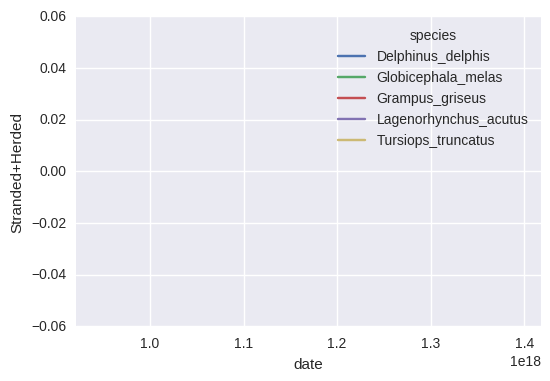

In [18]:
sb.tsplot(dfs_melt,time='date',condition='species',value='Stranded+Herded')

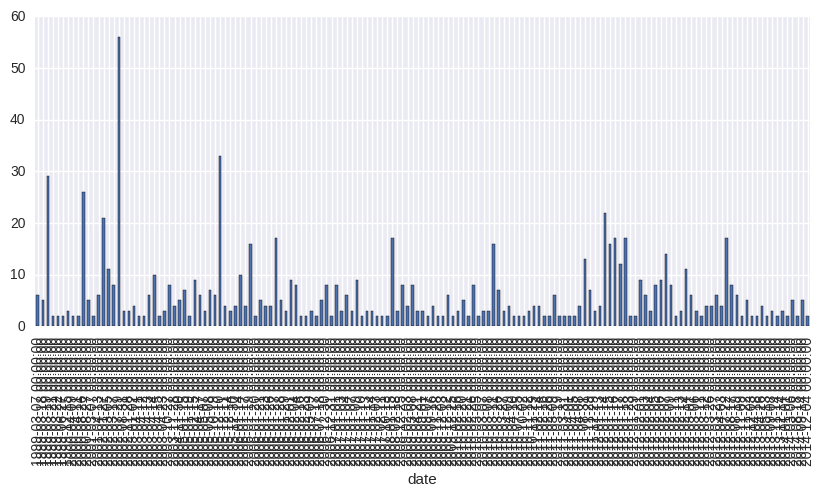

In [19]:
totals_TS = dfs.groupby(by='date')['total'].sum()
totals_TS.plot(kind='bar',style='o:',figsize=(10,4));